In [1]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.095
config.gpu_options.visible_device_list = "1"
set_session(tf.Session(config=config))

import keras
from keras import backend as K
from keras.models import model_from_json

import json
import numpy as np
from skimage import transform

from skopt import Optimizer
from skopt.space import Real

/home/nexes/miniconda3/envs/tf_py3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
from mnist import load_dataset

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

all_data = np.vstack((X_train, X_val, X_test))
all_data = all_data.reshape(-1, 28, 28)

subsample_indices = np.random.choice(len(all_data), 10000, replace=False)

all_data = all_data[subsample_indices]

results_dict = dict()

In [3]:
def rotate_dataset(dataset, angle):
    return np.array(list(map(lambda x: transform.rotate(x, angle), dataset)))

def get_X_and_y(dataset, angle):
    rotated_datased = rotate_dataset(dataset, angle)
    whole_dataset = np.vstack((dataset, rotated_datased)).reshape(-1, 784)
    shuffled_indices = np.arange(len(whole_dataset))
    np.random.shuffle(shuffled_indices)
    
    whole_dataset = whole_dataset[shuffled_indices]
    
    _labels = np.zeros(2*dataset.shape[0], dtype=bool)
    _labels[dataset.shape[0]:] = True
    _labels = _labels[:, None]
    
    whole_labels = np.array(np.hstack((_labels, ~_labels)), dtype=int)
    whole_labels = whole_labels[shuffled_indices]
    
    return whole_dataset, whole_labels

def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
    return

def target_function(params, test_str):
    global results_dict
    alpha = params[0]
    
    reset_weights(model)
#     print('here')
    X, y = get_X_and_y(all_data, alpha)
    val_border = -int(np.floor(X.shape[0]/20))
    test_border = -int(np.floor(X.shape[0]/5))
    X_val, y_val = X[val_border:], y[val_border:]
    X_test, y_test = X[test_border:val_border], y[test_border:val_border]
    X, y = X[:test_border], y[:test_border]
    
    batch_size = 128
    epochs = 2
    history = model.fit(X, y,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        validation_data=(X_val, y_val))
    _logloss, _accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    target_score = np.log(2) - _logloss
    
    results_dict[alpha] = {
        'score': target_score,
        'model_weights': model.get_weights()
    }
#     print('there')
    return target_score

In [7]:
with open('model_architecture.json', 'r') as iofile:
    model_architecture = json.load(iofile)    
model = model_from_json(model_architecture)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [8]:
dimensions = [Real(name='alpha', low=-180.0, high=180.0)]
opt = Optimizer(dimensions=dimensions)

In [9]:
opt.run(target_function, 30)


          fun: -0.004059647080588147
    func_vals: array([ 0.66448395,  0.67440935,  0.65931685,  0.68500582,  0.66984956,
        0.68207043,  0.64909773,  0.68576638,  0.68346576,  0.64861368,
        0.22586734,  0.29750911,  0.07995553, -0.00405965, -0.00204263,
        0.67903585,  0.68655177,  0.68348668, -0.00316861, -0.0033782 ])
       models: [GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=1),
             n_restarts_optimizer=2, noise='gaussian', normalize_y=True,
             optimizer='fmin_l_bfgs_b', random_state=1828258504), GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=1),
             n_restarts_optimizer=2, noise='gaussian', normalize_y=True,
             optimizer='fmin_l_bfgs_b', random_state=1828258504), GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kerne

In [10]:
import pickle
with open('optimizer_test_save.pcl', 'wb') as iofile:
    pickle.dump(opt, iofile)

In [13]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

def visualise(optimizer):    
    points = np.linspace(-180, 180, 360).reshape(-1, 1)
    mu, sigma = optimizer.models[-1].predict(optimizer.space.transform(list(points)), return_std=True)
    
    plt.figure(figsize=(15, 10))
    plt.plot(points, mu, "r", label="Upper bound by classifier")
#     plt.plot(points, mu+sigma, "g--")
#     plt.plot(points, mu-sigma, "g--")
    plt.scatter(optimizer.Xi, optimizer.yi, c='b', label='sampled points')

    _x = np.concatenate((points, points[::-1]))
    _y = np.concatenate(([mu[i] - sigma[i] for i in range(len(points))], 
                            [mu[i] + sigma[i] for i in range(len(points)-1, -1, -1)]))
    plt.fill(_x, _y, fc='r', alpha=.2, ec=None, label='+- sigma range')
    
    plt.hlines(np.log(2), -180, 180, label='log2')
    plt.ylabel('log2 - logloss')
    plt.xlabel('angle')
    
    plt.xlim((-185, 185))
    plt.legend()
    plt.tight_layout()
    plt.grid()
    plt.show()

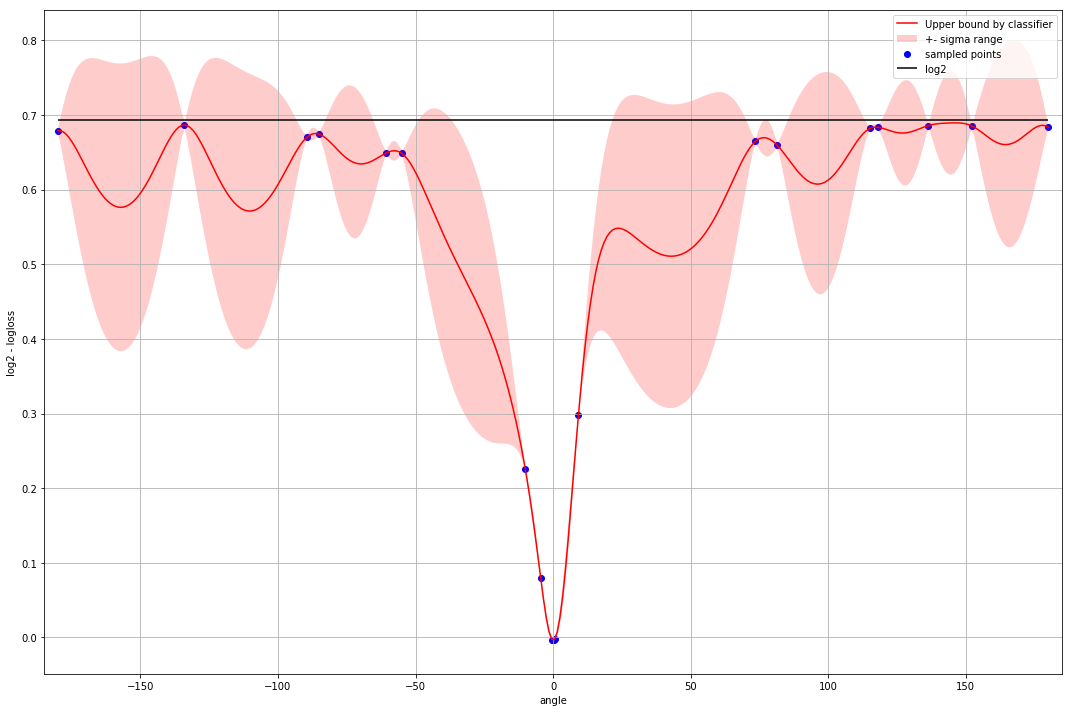

In [14]:
visualise(opt)